In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dtaidistance import dtw, dtw_c, dtw_ndim
from numpy.random import choice, shuffle
from torch import nn
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from time import time
from sklearn.neighbors import KNeighborsClassifier

from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
%load_ext autoreload
%autoreload 1

from preprocessing import *
from models import Encoder, Decoder, Sequence2Sequence

%aimport preprocessing
%aimport models

# Example of multidimensional time-series

In [3]:
# !mkdir -p data
# !wget https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/UCRArchive_2018.zip ../data
# !unzip data/UCRArchive_2018.zip -d ../data

In [4]:
# data_path = "../data/UCRArchive_2018/Earthquakes/Earthquakes_TRAIN.tsv"

In [5]:
# data = pd.read_csv(data_path, header=None, delimiter="\t").values

# # to remove Nan (only first columns)
# data = data[:, ~np.isnan(data).any(0)]

# X = data[:, 1:]
# y = data[:, 0].astype(np.short)

# B_Accelerometer preprocessing

[Link](https://github.com/mmalekzadeh/motion-sense/blob/master/data/B_Accelerometer_data.zip "")

In [6]:
def get_dataset_2(length):
    LABELS = [0, 1, 4, 5]

    labels = np.unique([x[:3] for x in os.listdir("../data/B_Accelerometer_data/")])
    dirs = os.listdir("../data/B_Accelerometer_data/")
    d = dict((label, i) for (i, label) in enumerate(labels))

    timeseries = {label: [] for label in d.values()}

    for dir_name in dirs:
        tmp = []
        for f in os.listdir("../data/B_Accelerometer_data/{}".format(dir_name)):
            data = pd.read_csv("../data/B_Accelerometer_data/{}/{}".format(dir_name, f), index_col=0)

            tmp.append(np.linalg.norm(data, axis=1))

        timeseries[d[dir_name[:3]]] = zscore(np.hstack(tmp))

    dataset = {label: [] for label in LABELS}
    for label in LABELS:
        X = timeseries[label][np.newaxis].T
        dataset[label].extend(slice_timeseries(X, length))


    max_count = min([len(x) for x in dataset.values()])
    for label, ts in dataset.items():
        dataset[label] = [ts[idx] for idx in choice(range(len(ts)), max_count, replace=False)]

    X = np.array([zscore(x) for _, ts in dataset.items() for x in ts])
    y = [np.repeat(label, len(ts)) for label, ts in dataset.items()]
    X = np.hstack(X).T
    y = np.hstack(y).T
    
    return X, y

In [7]:
# fig, axs = plt.subplots(len(LABELS), figsize=(10, 15))

# for i, label in enumerate(LABELS):
#     axs[i].plot(dataset[label][10])

# Accelerometer dataset 

- 1: Working at Computer
- 2: Standing Up, Walking and Going up\down stairs
- 3: Standing
- 4: Walking
- 5: Going Up\Down Stairs
- 6: Walking and Talking with Someone
- 7: Talking while Standing

In [8]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip -O ../data/Accelerometer.zip
# ! unzip ../data/Accelerometer.zip -d ./data

In [9]:
CHANNELS = ['0', '1', '2']
LABELS = [1, 3, 4, 5]

LENGTH = 100
start_ident = 200

In [10]:
def get_dataset_3():
    np.random.seed(0)


    dataset = {label: [] for label in LABELS}

    for i in range(1, 11):
        data_path = "../data/Activity Recognition from Single Chest-Mounted Accelerometer/{0}.csv".format(i)
        data = pd.read_csv(data_path,
                       names=['0', '1', '2', "labels"],
                       index_col=0,
                       dtype=np.float)

        for label in LABELS:
            X = get_class_timeseries(label, data, start_ident)
            X = np.linalg.norm(X, axis=1)[np.newaxis].T
            dataset[label].extend(slice_timeseries(X, LENGTH))

    max_count = min([len(x) for x in dataset.values()])
    for label, ts in dataset.items():
        dataset[label] = [ts[idx] for idx in choice(range(len(ts)), max_count, replace=False)]

    X = np.array([zscore(x) for _, ts in dataset.items() for x in ts])
    y = [np.repeat(label, len(ts)) for label, ts in dataset.items()]
    X = np.hstack(X).T
    y = np.hstack(y).T
    
    return X, y

# Experiment

In [11]:
device = torch.device("cuda")

def prepare_data(X, y, k, w):
    ds = SplittedDataset(X, y, k, w, device=device)
    train_ds, test_ds, valid_ds = train_test_valid_split(ds, 0.3, 0.2)

    train_set = DataLoader(train_ds, batch_size=1024, shuffle=True)
    test_set = DataLoader(test_ds, batch_size=1024, shuffle=True)
    valid_set = DataLoader(valid_ds, batch_size=256, shuffle=True)
    
    return train_set, test_set, valid_set

In [12]:
def get_model(hidden_dim, k, n_layers):
    input_dim = 2*k
    enc = Encoder(input_dim, hidden_dim, 1, n_layers, False)
    dec = Decoder(hidden_dim, input_dim, 1, n_layers)

    model = Sequence2Sequence(enc, dec)
    model.to(device)
    
    return model

In [13]:
from IPython.display import clear_output

def train(model, train_ds, optim, loss_fn, valid_ds, n_step):
    model.train()
    for step in range(n_step):
        it = iter(train_ds)
        train_loss = 0.
        for batch, _, _ in it:
            batch = batch.permute(1, 0, 2)
            optim.zero_grad()
            out = model(batch)
            loss = loss_fn(batch, out)

            loss.backward()
            optim.step()
            train_loss += loss.cpu().detach().numpy()

        if (step+1) % 500 == 0:
            valid_loss = valid(model, valid_ds, loss_fn)
            print("{:4d}: train loss: {:.3f}; valid loss: {:.3f}".format(step+1, train_loss, valid_loss))
            model.train()


def valid(model, valid_ds, loss_fn):
    model.eval()
    with torch.no_grad():
        loss = 0.
        it = iter(valid_ds)
        for batch, _, _ in it:
            batch = batch.permute(1, 0, 2)
            out = model(batch)
            loss += loss_fn(batch, out)
    
    return loss.cpu().detach().numpy()

In [14]:
def m(id1, id2, matrix):
    x, y = int(min(id1[0], id2[0])), int(max(id1[0], id2[0]))
    return matrix[x, y]

def get_metric(matrix):
    return lambda id1, id2: m(id1, id2, matrix)

def workflow(w, k, hidden_dim, n_layers, length, n_step=6000):
    X, y = get_dataset_2(length)
    train_set, test_set, valid_set = prepare_data(X, y, k, w)
    model = get_model(hidden_dim, k, n_layers)
    loss_fn = nn.MSELoss()
    optim = torch.optim.Adam(model.parameters())
    train(model, train_set, optim, loss_fn, test_set, n_step)
    torch.save(model.state_dict(), "../data/w={};k={};nl={};length={}".format(w, k, n_layers, length))
    valid(model, test_set, loss_fn)
    valid_it = iter(valid_set)
    batch, timeseries, labels = next(valid_it)
    timeseries = timeseries.numpy()

    scores_ts = []
    scores_hidden = []

    t = time()
    matrix_ts = dtw.distance_matrix(timeseries, use_c=True)
    print("raw_ts: {:.3f}".format(time() - t))
    t = time()
    hiddens = model.encoder(batch.permute(1, 0, 2))[0].permute(1, 0, 2).detach().cpu().numpy()
    matrix_hidden = dtw_ndim.distance_matrix(hiddens)
    print("hidden_ts: {:.3f}".format(time() - t))
    idxs = np.arange(len(timeseries)).reshape(-1, 1)

    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(idxs, labels.cpu().numpy(), test_size=0.4)

        clf = KNeighborsClassifier(metric=get_metric(matrix_ts), algorithm="brute")
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        scores_ts.append(score)
        clf = KNeighborsClassifier(metric=get_metric(matrix_hidden), algorithm="brute")
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        scores_hidden.append(score)

    print("Raw ts score: {:.3f} +- {:.3f}".format(np.mean(scores_ts), np.std(scores_ts)))    
    print("Hidden ts score: {:.3f} +- {:.3f}".format(np.mean(scores_hidden), np.std(scores_hidden)))
    
    return scores_ts

In [15]:
LENGTHS = [100]
W = [3, 5, 7]
K = [3, 5, 7]
HIDDEN_DIM = [4, 6]
N_LAYERS = [1, 2, 4]
raw_scores = []
for w in W:
    for k in K:
        for length in LENGTHS:
            for hidden_dim in HIDDEN_DIM:
                for n_layers in N_LAYERS:
                    print("{:#^80}".format(" w={}; k={}; hidden={}; nl={} ".format(w, k, hidden_dim, n_layers)))
                    
                    raw_scores += workflow(w, k, hidden_dim, n_layers, length, 2000)

print("Raw ts score: {:.3f} +- {:.3f}".format(np.mean(raw_scores), np.std(raw_scores)))    

########################### w=3; k=3; hidden=4; nl=1 ###########################
 500: train loss: 0.832; valid loss: 0.418
1000: train loss: 0.705; valid loss: 0.353
1500: train loss: 0.661; valid loss: 0.333
2000: train loss: 0.647; valid loss: 0.322
raw_ts: 607.128
hidden_ts: 453.845
Raw ts score: 0.680 +- 0.039
Hidden ts score: 0.704 +- 0.042
########################### w=3; k=3; hidden=4; nl=2 ###########################
 500: train loss: 0.830; valid loss: 0.409
1000: train loss: 0.788; valid loss: 0.392
1500: train loss: 0.769; valid loss: 0.382
2000: train loss: 0.662; valid loss: 0.325
raw_ts: 608.901
hidden_ts: 444.392
Raw ts score: 0.679 +- 0.043
Hidden ts score: 0.622 +- 0.043
########################### w=3; k=3; hidden=4; nl=4 ###########################
 500: train loss: 0.851; valid loss: 0.419
1000: train loss: 0.785; valid loss: 0.392
1500: train loss: 0.769; valid loss: 0.378
2000: train loss: 0.744; valid loss: 0.369
raw_ts: 604.930
hidden_ts: 476.735
Raw ts score: 

In [19]:
LENGTHS = [100]
W = [3, 5, 7]
K = [3, 5, 7]
HIDDEN_DIM = [4, 6, 10]
N_LAYERS = [4]
raw_scores = []
for w in W:
    for k in K:
        for length in LENGTHS:
            for hidden_dim in HIDDEN_DIM:
                for n_layers in N_LAYERS:
                    print("{:#^80}".format(" w={}; k={}; hidden={}; nl={} ".format(w, k, hidden_dim, n_layers)))
                    
                    raw_scores += workflow(w, k, hidden_dim, n_layers, length, 4000)

print("Raw ts score: {:.3f} +- {:.3f}".format(np.mean(raw_scores), np.std(raw_scores)))    

########################### w=3; k=3; hidden=4; nl=4 ###########################
 500: train loss: 1.321; valid loss: 0.653
1000: train loss: 0.826; valid loss: 0.414
1500: train loss: 0.806; valid loss: 0.401
2000: train loss: 0.791; valid loss: 0.394
2500: train loss: 0.775; valid loss: 0.387
3000: train loss: 0.756; valid loss: 0.382
3500: train loss: 0.753; valid loss: 0.379
4000: train loss: 0.755; valid loss: 0.377
raw_ts: 582.760
hidden_ts: 437.862
Raw ts score: 0.699 +- 0.037
Hidden ts score: 0.570 +- 0.048
########################### w=3; k=3; hidden=6; nl=4 ###########################
 500: train loss: 1.337; valid loss: 0.672
1000: train loss: 0.790; valid loss: 0.395
1500: train loss: 0.772; valid loss: 0.379
2000: train loss: 0.721; valid loss: 0.357
2500: train loss: 0.654; valid loss: 0.324
3000: train loss: 0.643; valid loss: 0.316
3500: train loss: 0.638; valid loss: 0.313
4000: train loss: 0.636; valid loss: 0.311
raw_ts: 588.209
hidden_ts: 442.137
Raw ts score: 0.674

# See decodered peaces of timeseries

In [16]:
id0 = 5
id1 = 5
w = 3
k = 5
hidden_dim = 6
length = 100
X, y = get_dataset_2(length)
n_layers = 1
train_set, test_set, valid_set = prepare_data(X, y, k, w)
model = get_model(hidden_dim, k, n_layers)
valid_it = iter(valid_set)
batch, timeseries, labels = next(valid_it)
timeseries = timeseries.numpy()
model.load_state_dict(torch.load("../data/w={};k={};nl={};length={}".format(w, k, n_layers, length)))

x_out = model(batch.permute(1, 0, 2)).permute(1, 0, 2).cpu().detach().numpy()

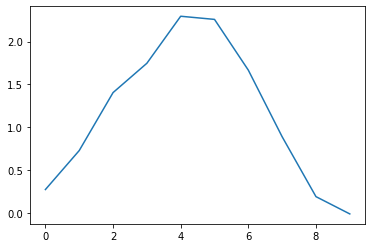

In [17]:
plt.plot(batch[id0, id1].cpu())

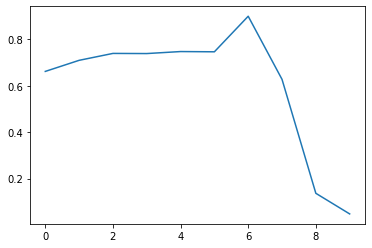

In [18]:
plt.plot(x_out[id0, id1])

## Classification on raw time-series

In [ ]:
%%time
matrix_ts = dtw.distance_matrix(timeseries, use_c=True)

In [ ]:
clf = KNeighborsClassifier(metric=get_metric(matrix_ts), algorithm="brute")
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

## Hidden states classification

In [ ]:
%%time
hiddens = model.encoder(batch.permute(1, 0, 2))[0].permute(1, 0, 2).detach().cpu().numpy()
matrix_hidden = dtw_ndim.distance_matrix(hiddens)

In [ ]:
clf = KNeighborsClassifier(metric=get_metric(matrix_hidden), algorithm="brute")
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

# Statistic

In [ ]:
scores_ts = []
scores_hidden = []

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(idxs, labels.cpu().numpy(), test_size=0.3)

    clf = KNeighborsClassifier(metric=get_metric(matrix_ts), algorithm="brute")
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores_ts.append(score)
    clf = KNeighborsClassifier(metric=get_metric(matrix_hidden), algorithm="brute")
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores_hidden.append(score)
    
print("{:.3f}".format(np.mean(scores_ts)))    
print("{:.3f}".format(np.mean(scores_hidden)))